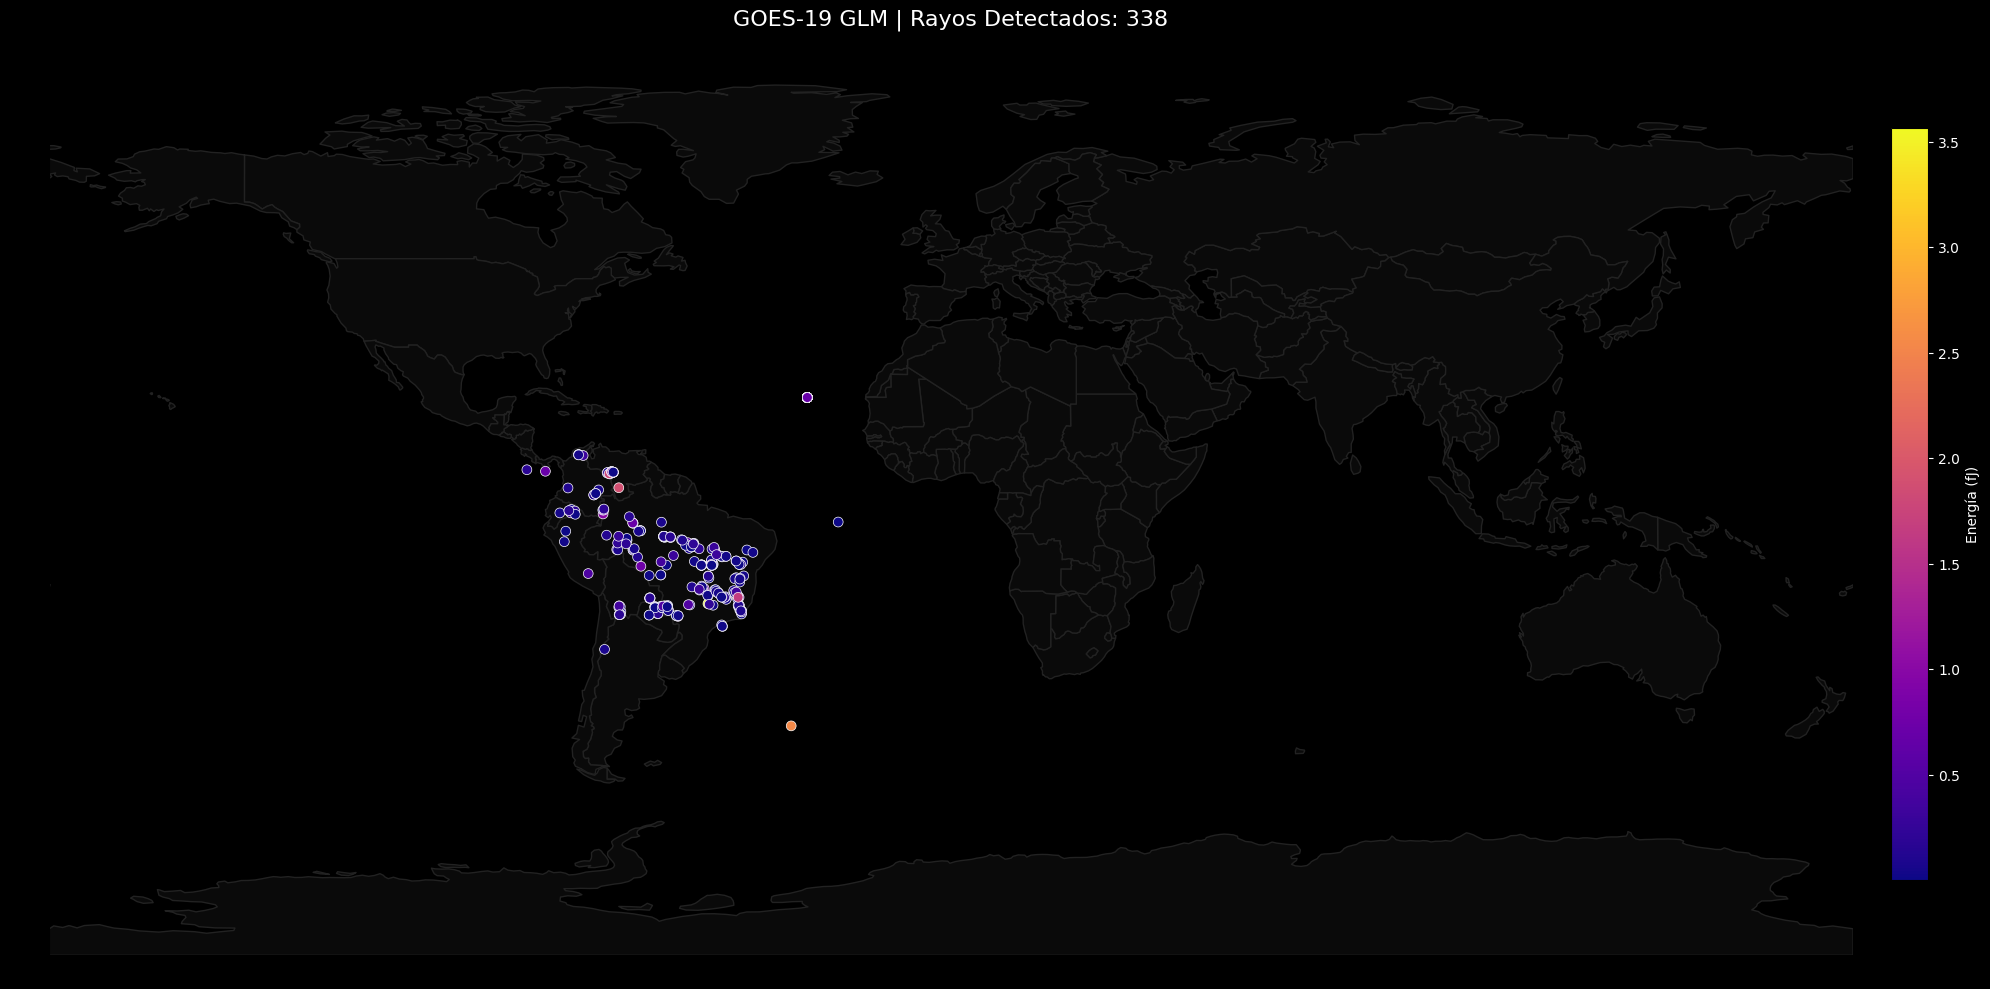

In [2]:
import netCDF4 as nc
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import os

# --- 1. CARGA DEL MAPA ---
map_file = "countries.geojson"
# Asumimos que ya existe por las corridas anteriores
world = gpd.read_file(map_file)

# --- 2. LECTURA DEL GOES-19 GLM ---
file_path = 'OR_GLM-L2-LCFA_G19_s20260030000000_e20260030000200_c20260030000220.nc'
ds = nc.Dataset(file_path)

lats = np.array(ds.variables['flash_lat'][:])
lons = np.array(ds.variables['flash_lon'][:])
energy = np.array(ds.variables['flash_energy'][:])

# Cerramos el dataset pronto para liberar memoria
ds.close()

# Creamos el GeoDataFrame
df_lightning = pd.DataFrame({'lat': lats, 'lon': lons, 'energy': energy})
geometry = [Point(xy) for xy in zip(df_lightning.lon, df_lightning.lat)]
gdf_lightning = gpd.GeoDataFrame(df_lightning, geometry=geometry, crs="EPSG:4326")

# --- 3. VISUALIZACIÓN ---
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_facecolor('#000000') # Fondo negro

# Dibujamos el mundo con un gris muy oscuro
world.plot(ax=ax, color='#0a0a0a', edgecolor='#222222', zorder=1)

# Dibujamos los rayos
if not gdf_lightning.empty:
    # CAMBIO IMPORTANTE: s=50 (tamaño fijo grande) y zorder=5 (encima de todo)
    scatter = ax.scatter(
        gdf_lightning.lon, 
        gdf_lightning.lat, 
        c=gdf_lightning.energy, 
        s=50,             # Forzamos tamaño visible en escala global
        cmap='plasma', 
        alpha=1.0, 
        edgecolors='white', 
        linewidths=0.5,
        zorder=5          # Asegura que esté ARRIBA del mapa
    )
    cbar = plt.colorbar(scatter, fraction=0.02, pad=0.02)
    cbar.set_label('Energía (fJ)', color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
else:
    print("El archivo no tiene rayos (Flashes: 0)")

# Ajustes de visualización global
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
ax.set_aspect('equal')

# Título dinámico
plt.title(f"GOES-19 GLM | Rayos Detectados: {len(gdf_lightning)}", 
          color='white', fontsize=16, pad=20)

plt.tight_layout()
fig.patch.set_facecolor('#000000') # Fondo de la figura también negro
plt.show()

AttributeError: 'GeoAxes' object has no attribute 'set_tight_geometry'

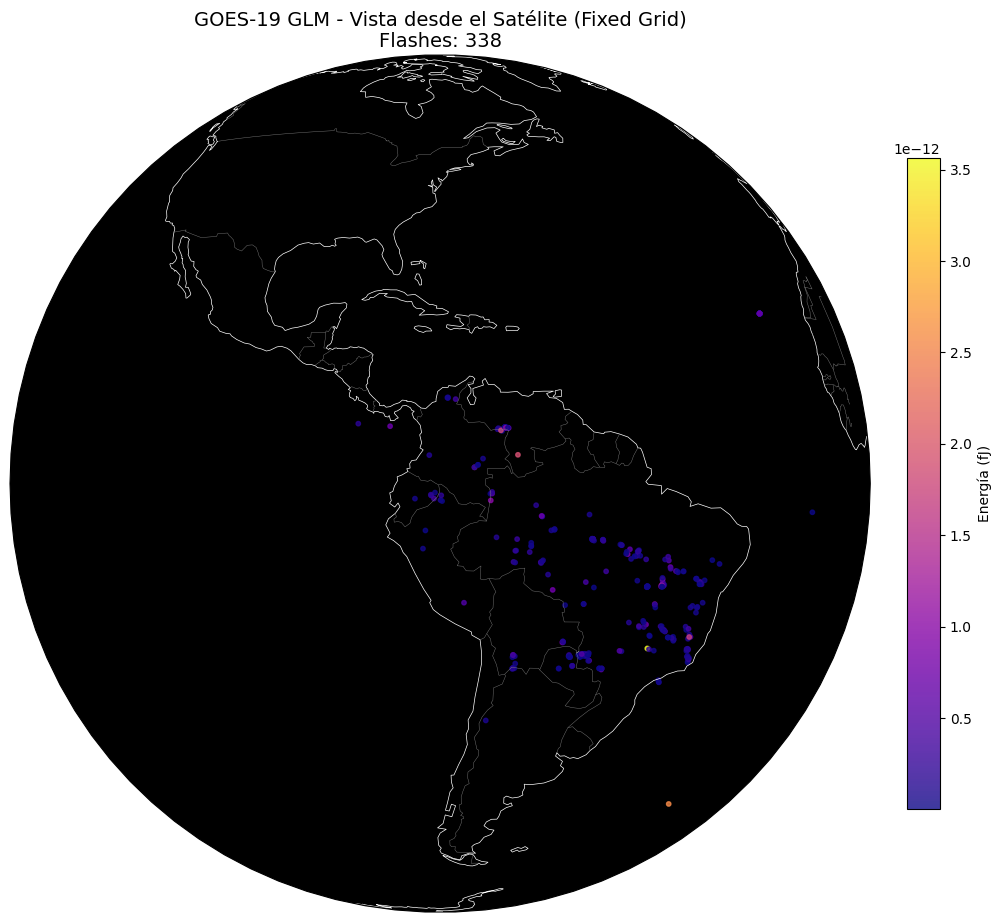

In [3]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# 1. Abrir el archivo
file_path = 'OR_GLM-L2-LCFA_G19_s20260030000000_e20260030000200_c20260030000220.nc'
ds = nc.Dataset(file_path)

# Extraer coordenadas (el GLM L2 guarda los eventos en Lat/Lon)
lats = ds.variables['flash_lat'][:]
lons = ds.variables['flash_lon'][:]
energy = ds.variables['flash_energy'][:]

# 2. Definir la proyección del GOES-19 (Geostationary)
# La longitud central del GOES-19 es aproximadamente -75.2 grados (GOES-East position)
goes_ext = ccrs.Geostationary(central_longitude=-75.2, 
                             satellite_height=35786023.0)

# 3. Visualización
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=goes_ext)

# Fondo y detalles del mapa
ax.set_facecolor('black')
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.3)

# Dibujar el "limbo" de la Tierra (el borde del disco)
ax.set_global() 

# Graficar los rayos
# IMPORTANTE: Aunque usemos la proyección Geostationary, 
# los datos de entrada están en lat/lon (PlateCarree)
scatter = ax.scatter(lons, lats, 
                    c=energy, s=10, 
                    cmap='plasma', 
                    transform=ccrs.PlateCarree(), # Decimos que los datos son lat/lon
                    alpha=0.8)

plt.colorbar(scatter, label='Energía (fJ)', fraction=0.035, pad=0.04)
plt.title("GOES-19 GLM - Vista desde el Satélite (Fixed Grid)\n" + 
          f"Flashes: {len(lats)}", color='black', fontsize=14)

# Ver el disco completo
ax.set_tight_geometry()

plt.show()
ds.close()

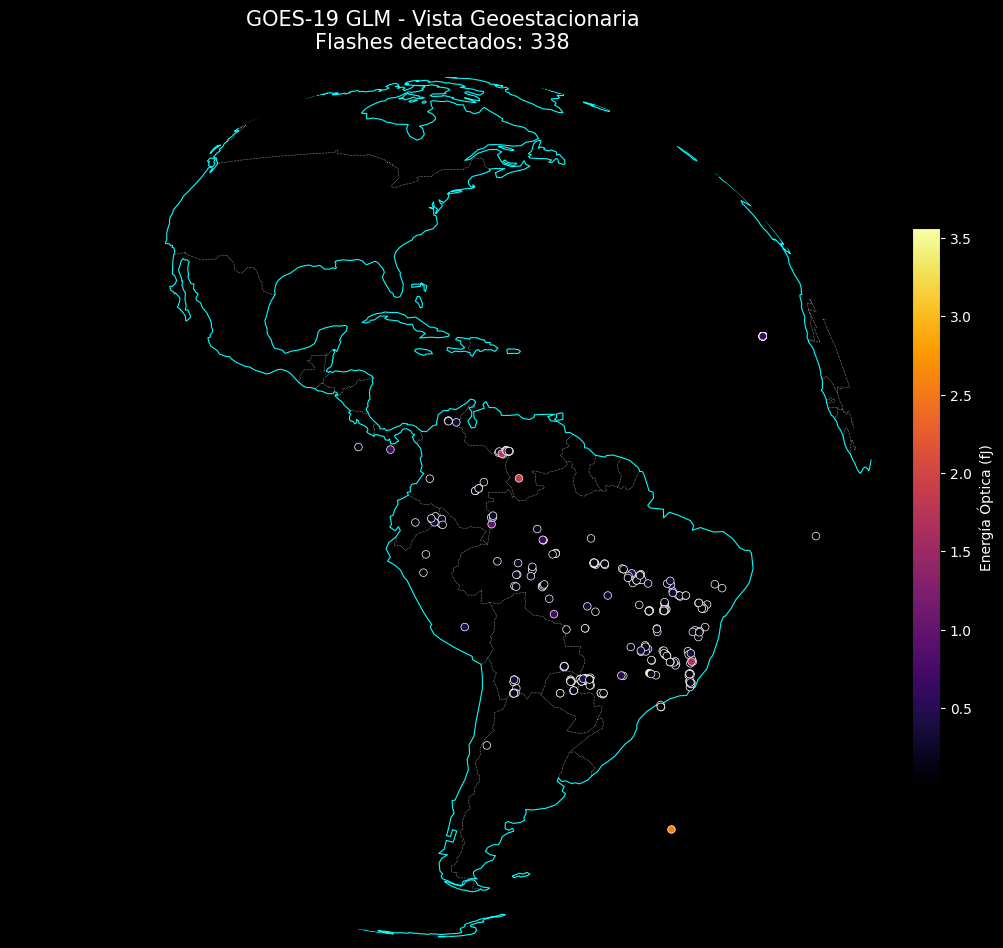

In [4]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# 1. Abrir el archivo
file_path = 'OR_GLM-L2-LCFA_G19_s20260030000000_e20260030000200_c20260030000220.nc'
ds = nc.Dataset(file_path)

# Extraer coordenadas y energía (convertimos a numpy para asegurar limpieza)
lats = np.array(ds.variables['flash_lat'][:])
lons = np.array(ds.variables['flash_lon'][:])
energy = np.array(ds.variables['flash_energy'][:])
area_km2 = np.array(ds.variables['flash_area'][:])

# 2. Definir la proyección del GOES-19
goes_ext = ccrs.Geostationary(central_longitude=-75.0, 
                             satellite_height=35786023.0)

# 3. Visualización
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=goes_ext)

# Fondo negro para que resalten los rayos
ax.set_facecolor('black')

# Agregamos elementos del mapa
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.4, linestyle=':')

# 4. Graficar los rayos
# CAMBIO CLAVE: Definimos un tamaño de punto fijo 's=30' para verlos bien.
# Si quieres usar el área, usa s=area_km2 * 2 (multiplica en vez de dividir)
if len(lats) > 0:
    scatter = ax.scatter(lons, lats, 
                        c=energy, 
                        s=30,           # Tamaño fijo y grande para que sea visible
                        cmap='inferno', 
                        transform=ccrs.PlateCarree(), 
                        alpha=1.0,      # Opacidad total
                        edgecolors='white',
                        linewidths=0.5,
                        zorder=10)      # Asegura que esté por encima del mapa

    cbar = plt.colorbar(scatter, fraction=0.03, pad=0.04)
    cbar.set_label('Energía Óptica (fJ)', color='white')
    # Ajustar etiquetas de colorbar a blanco
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
else:
    print("⚠️ El archivo no contiene flashes en estos 20 segundos.")

# Ver el disco completo
ax.set_global() 

plt.title(f"GOES-19 GLM - Vista Geoestacionaria\nFlashes detectados: {len(lats)}", 
          fontsize=15, color='white', pad=20)

# El fondo de la figura (fuera del mapa) también negro
fig.patch.set_facecolor('black')

plt.show()
ds.close()

Graficando 338 puntos...


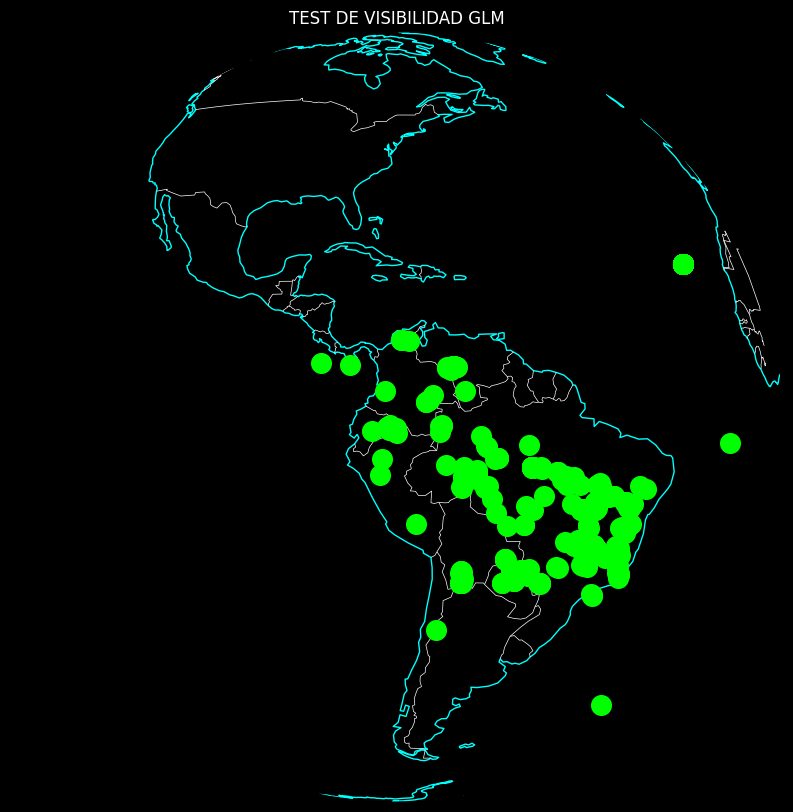

In [5]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# 1. Datos
file_path = 'OR_GLM-L2-LCFA_G19_s20260030000000_e20260030000200_c20260030000220.nc'
ds = nc.Dataset(file_path)
lats = np.array(ds.variables['flash_lat'][:])
lons = np.array(ds.variables['flash_lon'][:])
ds.close()

# 2. Proyección
goes_proj = ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=goes_proj)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# 3. Capas base (con zorder bajo)
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5, zorder=1)

# 4. Dibujar Rayos (con zorder alto y tamaño exagerado para testeo)
if len(lats) > 0:
    # USAMOS UN TAMAÑO DE 200 Y COLOR LIMA PARA QUE SEA IMPOSIBLE NO VERLOS
    ax.scatter(lons, lats, 
               color='lime', 
               s=200, 
               transform=ccrs.PlateCarree(), 
               zorder=10, 
               alpha=1)
    print(f"Graficando {len(lats)} puntos...")
else:
    print("No hay datos para graficar.")

ax.set_global()
plt.title("TEST DE VISIBILIDAD GLM", color='white')
plt.show()

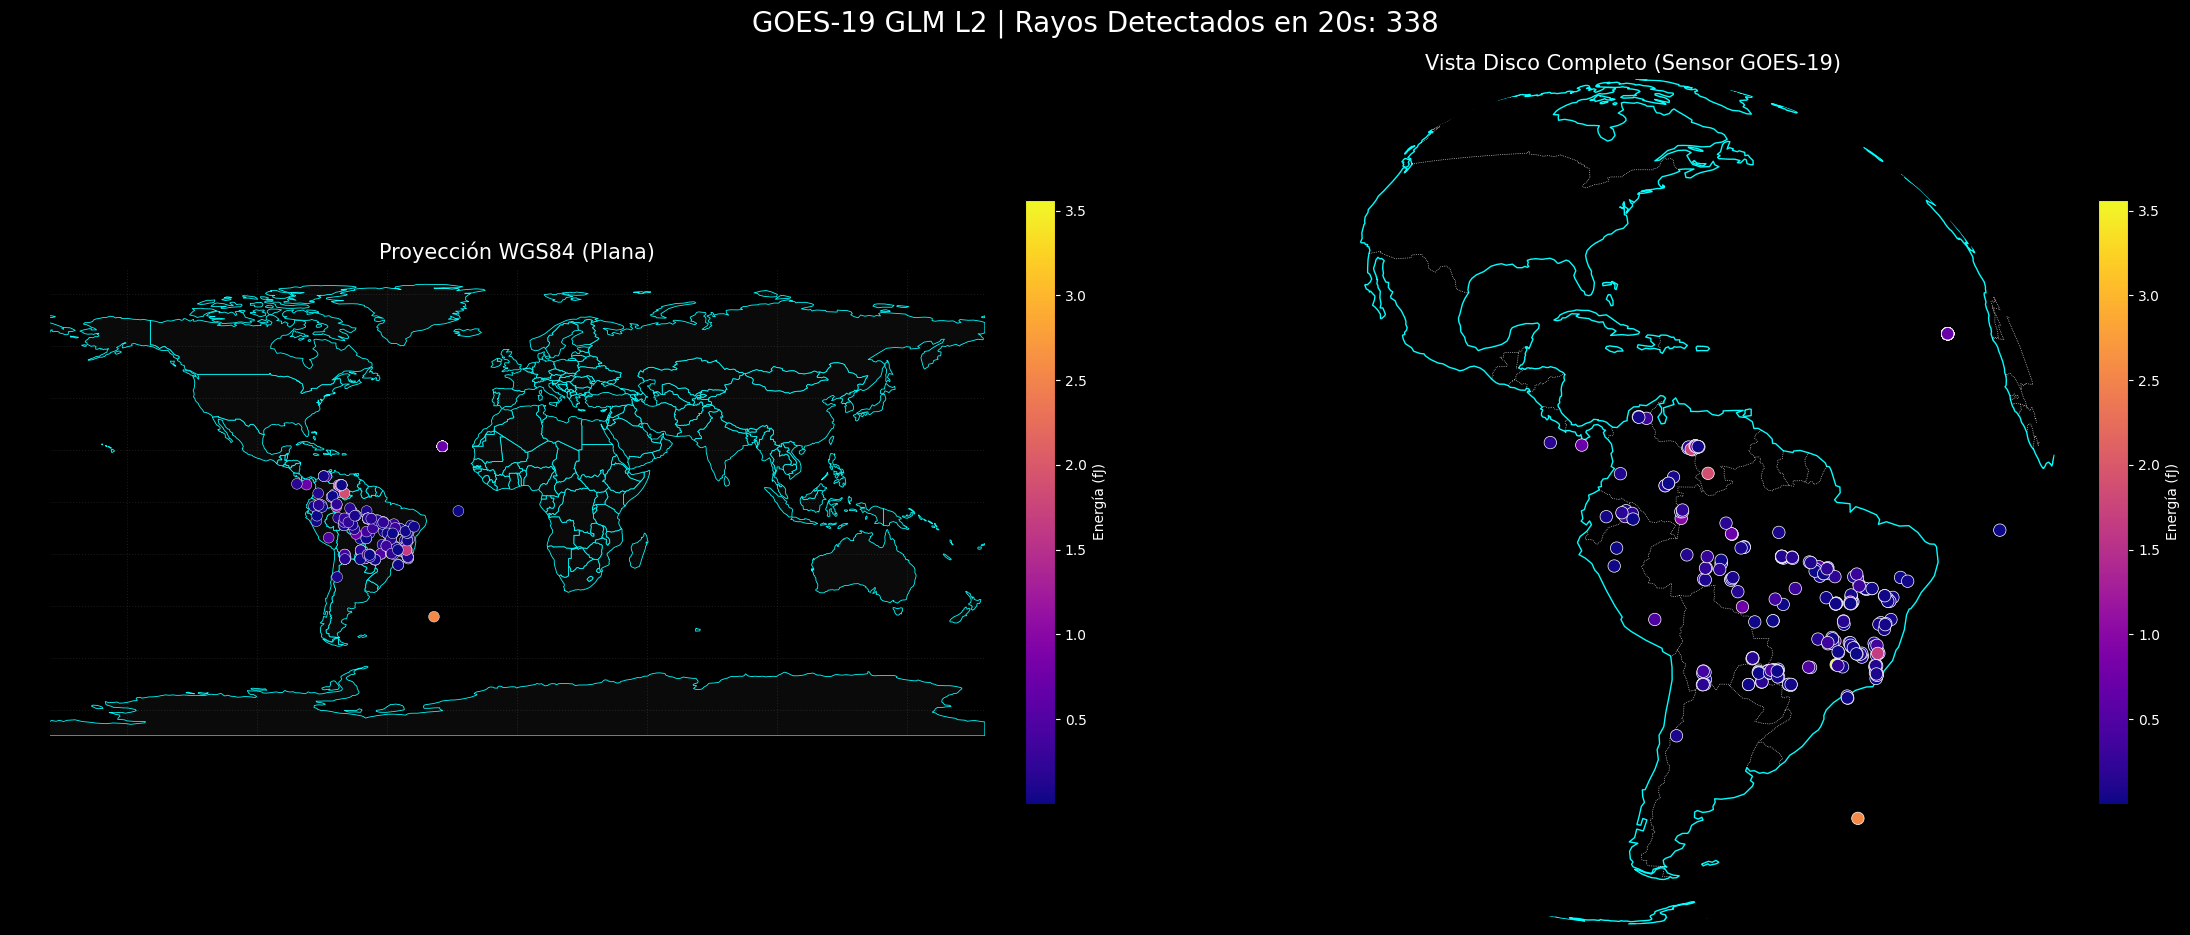

In [6]:
import netCDF4 as nc
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# --- 1. LECTURA DE DATOS ---
file_path = 'OR_GLM-L2-LCFA_G19_s20260030000000_e20260030000200_c20260030000220.nc'
ds = nc.Dataset(file_path)

lats = np.array(ds.variables['flash_lat'][:])
lons = np.array(ds.variables['flash_lon'][:])
energy = np.array(ds.variables['flash_energy'][:])
ds.close()

# Crear GeoDataFrame para el mapa plano
df = pd.DataFrame({'lat': lats, 'lon': lons, 'energy': energy})
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Carga de mapa base para la vista izquierda (WGS84)
map_file = "countries.geojson"
world = gpd.read_file(map_file) if os.path.exists(map_file) else None

# --- 2. GENERACIÓN DE AMBOS MAPAS JUNTOS ---
fig = plt.figure(figsize=(22, 10))
fig.patch.set_facecolor('black')

# ----- MAPA 1: VISTA GLOBAL (WGS84) -----
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_facecolor('black')

if world is not None:
    # Borde costero celeste/cian como pediste
    world.plot(ax=ax1, color='#0a0a0a', edgecolor='cyan', linewidth=0.6, zorder=1)

if not gdf.empty:
    sc1 = ax1.scatter(gdf.lon, gdf.lat, c=gdf.energy, s=60, 
                      cmap='plasma', alpha=1.0, edgecolors='white', 
                      linewidths=0.3, zorder=5)
    cbar1 = plt.colorbar(sc1, ax=ax1, fraction=0.03, pad=0.04)
    cbar1.set_label('Energía (fJ)', color='white')
    cbar1.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')

ax1.set_title("Proyección WGS84 (Plana)", color='white', fontsize=15)
ax1.set_xlim([-180, 180])
ax1.set_ylim([-90, 90])
ax1.set_aspect('equal')
ax1.grid(True, linestyle=':', alpha=0.1, color='white')

# ----- MAPA 2: VISTA SATÉLITE (DISCO COMPLETO) -----
# Definimos la proyección del GOES-19
goes_proj = ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0)
ax2 = fig.add_subplot(1, 2, 2, projection=goes_proj)
ax2.set_facecolor('black')

# Borde costero cian y límites del disco
ax2.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1, zorder=1)
ax2.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5, linestyle=':', zorder=1)

if not gdf.empty:
    # IMPORTANTE: s=80 para que sean visibles y transform para que sepa que son Lat/Lon
    sc2 = ax2.scatter(lons, lats, c=energy, s=80, 
                      cmap='plasma', alpha=1.0, edgecolors='white', 
                      linewidths=0.5, transform=ccrs.PlateCarree(), zorder=10)
    
    cbar2 = plt.colorbar(sc2, ax=ax2, fraction=0.03, pad=0.04)
    cbar2.set_label('Energía (fJ)', color='white')
    cbar2.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')

ax2.set_global() # Ver el disco completo del mundo
ax2.set_title("Vista Disco Completo (Sensor GOES-19)", color='white', fontsize=15)

plt.suptitle(f"GOES-19 GLM L2 | Rayos Detectados en 20s: {len(lats)}", 
             color='white', fontsize=20, y=0.96)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

✅ ÉXITO: 338 rayos encontrados.
📍 Rango Lat: -44.22 a 21.30
📍 Rango Lon: -84.63 a -22.51


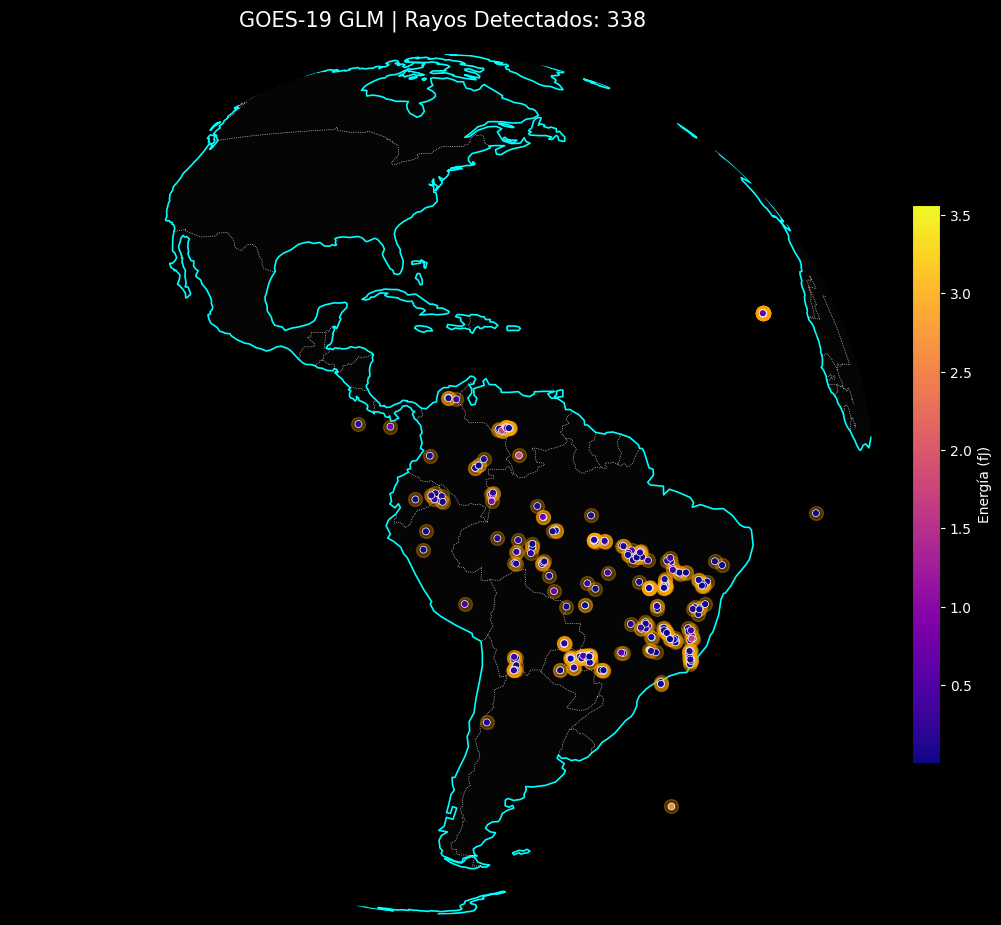

In [7]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. CARGA Y LIMPIEZA DE DATOS
file_path = 'OR_GLM-L2-LCFA_G19_s20260030000000_e20260030000200_c20260030000220.nc'
ds = nc.Dataset(file_path)

# Usamos variables de "flash" que son las más estables
lats = np.array(ds.variables['flash_lat'][:])
lons = np.array(ds.variables['flash_lon'][:])
energy = np.array(ds.variables['flash_energy'][:])
ds.close()

# DEBUG: Verificar si hay datos
if len(lats) == 0:
    print("❌ ERROR: El archivo no contiene rayos.")
else:
    print(f"✅ ÉXITO: {len(lats)} rayos encontrados.")
    print(f"📍 Rango Lat: {lats.min():.2f} a {lats.max():.2f}")
    print(f"📍 Rango Lon: {lons.min():.2f} a {lons.max():.2f}")

# 2. CONFIGURACIÓN DE PROYECCIÓN
# Usamos Geostationary para la vista de disco
goes_crs = ccrs.Geostationary(central_longitude=-75.0)

fig = plt.figure(figsize=(12, 12), facecolor='black')
ax = plt.axes(projection=goes_crs)
ax.set_facecolor('black')

# 3. CAPAS BASE (El borde cian que te gusta)
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1.2, zorder=2)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5, linestyle=':', zorder=2)
ax.add_feature(cfeature.LAND, facecolor='#050505', zorder=1)

# 4. EL DIBUJO DE LOS RAYOS
# Usamos scatter pero con transform=PlateCarree para que Cartopy haga la conversión
if len(lats) > 0:
    # Dibujamos un "resplandor" detrás de cada rayo (glow effect)
    ax.scatter(lons, lats, color='orange', s=100, alpha=0.3, 
               transform=ccrs.PlateCarree(), zorder=3)
    
    # El punto central del rayo
    scatter = ax.scatter(lons, lats, c=energy, s=25, cmap='plasma', 
                         edgecolors='white', linewidths=0.5,
                         transform=ccrs.PlateCarree(), zorder=4)
    
    # Ajustar la vista para que NO sea global si quieres verlos de cerca
    # ax.set_extent([lons.min()-5, lons.max()+5, lats.min()-5, lats.max()+5], crs=ccrs.PlateCarree())
    
    cbar = plt.colorbar(scatter, fraction=0.03, pad=0.04)
    cbar.set_label('Energía (fJ)', color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Mostrar todo el disco
ax.set_global()

plt.title(f"GOES-19 GLM | Rayos Detectados: {len(lats)}", color='white', pad=20, fontsize=15)
plt.show()

In [8]:
import glob
import os

ruta_base = "../../data/raw"

# El **/ indica búsqueda recursiva en todas las subcarpetas
patron = os.path.join(ruta_base, "**/OR_GLM-L2-LCFA_G19_*.nc")

# recursive=True es OBLIGATORIO para que el ** funcione
archivos = sorted(glob.glob(patron, recursive=True))

print(f"✅ Total de archivos LCFA (G19) encontrados: {len(archivos)}")

✅ Total de archivos LCFA (G19) encontrados: 4320


DEBUG: Graficando 338 puntos válidos.
DEBUG: Rango Lon: -84.63453674316406 a -22.509693145751953
DEBUG: Rango Lat: -44.222408294677734 a 21.301803588867188


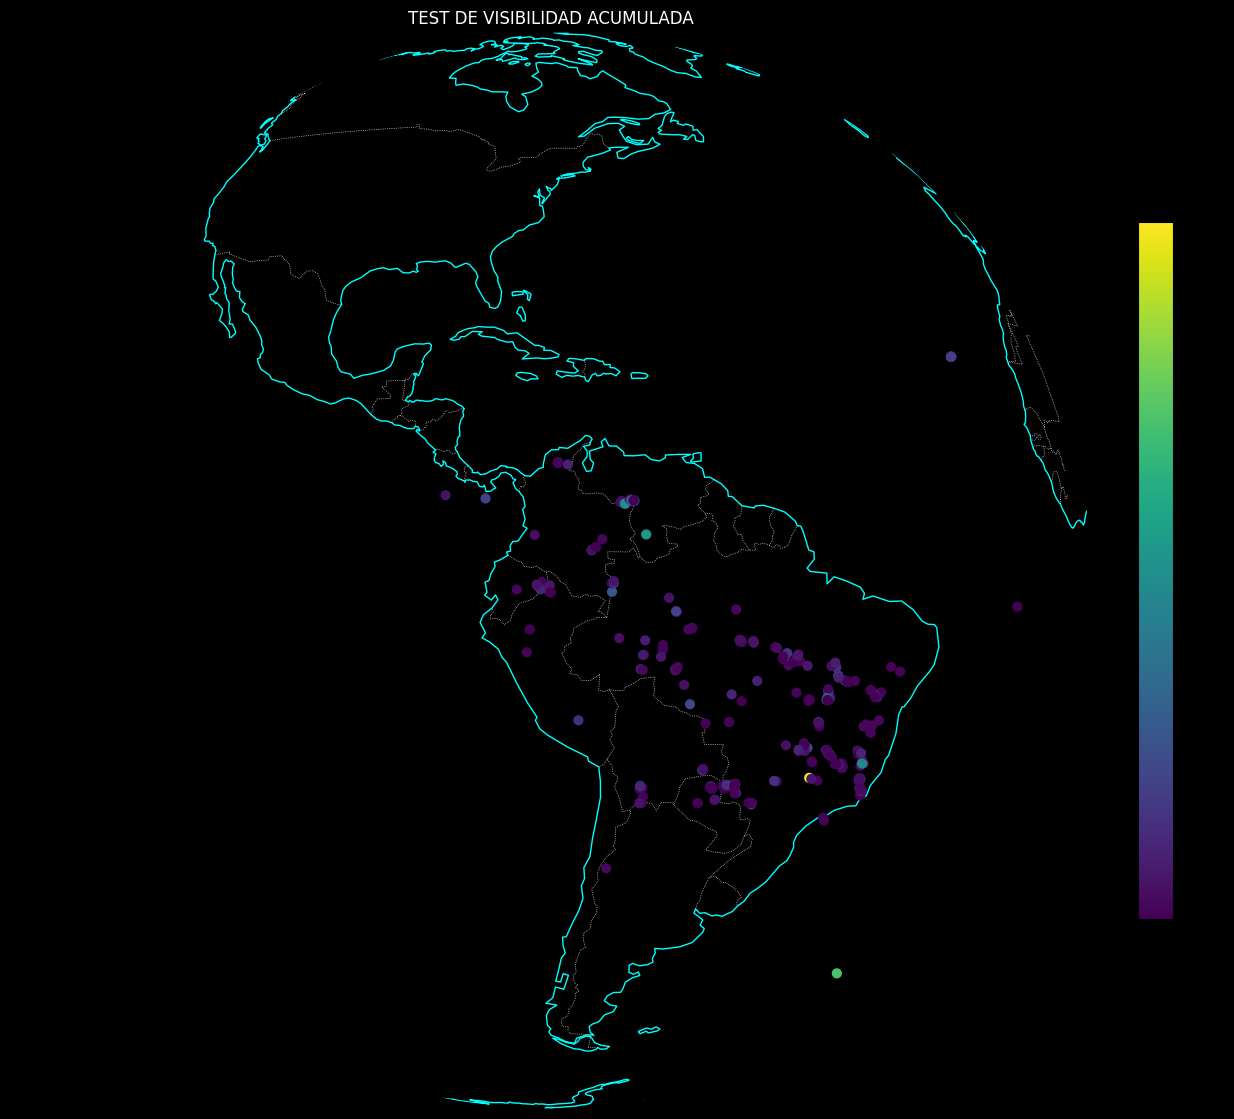

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- 1. LIMPIEZA PREVENTIVA ---
# Eliminamos cualquier valor infinito o NaN que pueda arruinar el plot
mask = ~np.isnan(lats) & ~np.isnan(lons)
lons_clean = lons[mask]
lats_clean = lats[mask]
energy_clean = energy[mask]

print(f"DEBUG: Graficando {len(lons_clean)} puntos válidos.")
print(f"DEBUG: Rango Lon: {lons_clean.min()} a {lons_clean.max()}")
print(f"DEBUG: Rango Lat: {lats_clean.min()} a {lats_clean.max()}")

# --- 2. PLOTEO FORZADO ---
fig = plt.figure(figsize=(15, 15), facecolor='black')
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0))
ax.set_facecolor('black')

# Capas base con zorder bajo
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5, linestyle=':', zorder=1)

# DIBUJO DE RAYOS (Con zorder alto y sin transparencia para testear)
if len(lons_clean) > 0:
    # Primero un scatter simple para ver si aparecen
    scatter = ax.scatter(lons_clean, lats_clean, 
                         c=energy_clean, 
                         s=40,               # Tamaño notable
                         cmap='viridis',     # Viridis es más brillante que inferno para testear
                         alpha=1.0,          # Opacidad total
                         transform=ccrs.PlateCarree(), 
                         zorder=10)          # ENCIIMA DE TODO
    
    plt.colorbar(scatter, label='Energía', fraction=0.03, pad=0.04)
else:
    print("No hay coordenadas válidas para mostrar.")

ax.set_global()
plt.title("TEST DE VISIBILIDAD ACUMULADA", color='white')
plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x1200 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y tormenta_goes19.mp4


🎬 Generando video... esto tomará un tiempo dependiendo de la cantidad de archivos.


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x1200', '-pix_fmt', 'rgba', '-framerate', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'tormenta_goes19.mp4']' returned non-zero exit status 255.

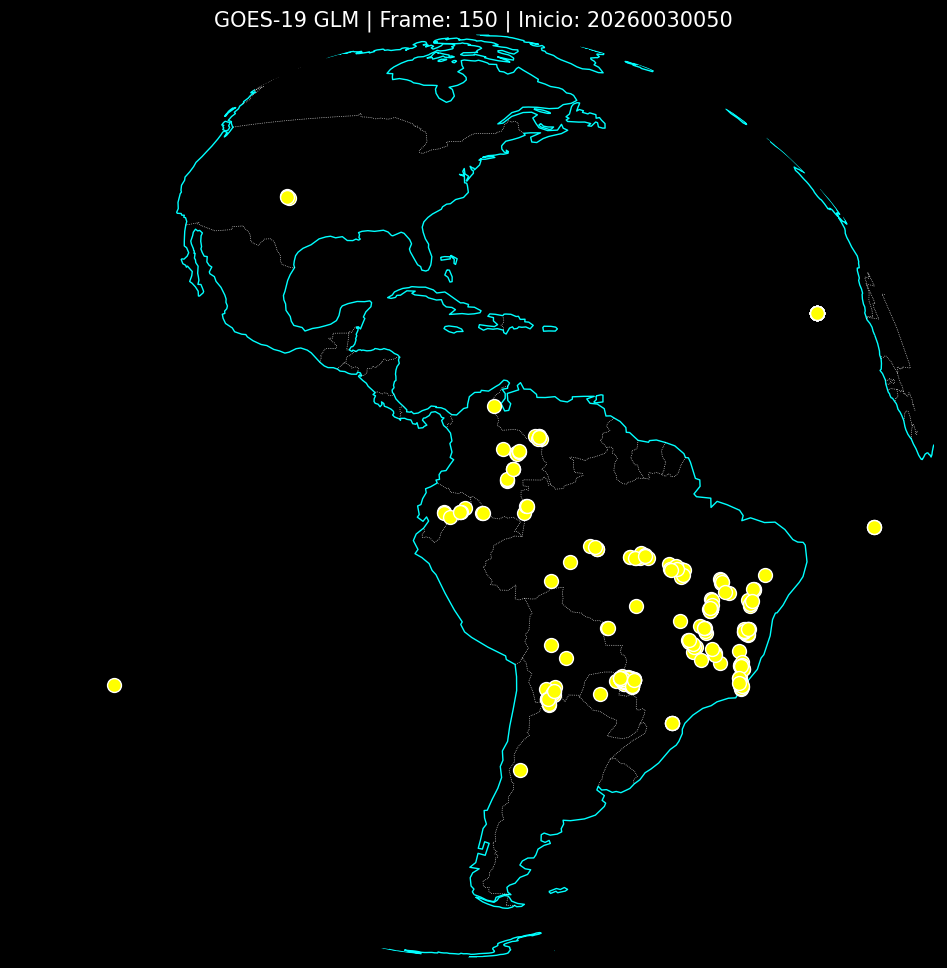

In [10]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation

# --- 1. PREPARACIÓN DE LA FIGURA ---
fig = plt.figure(figsize=(12, 12), facecolor='black')
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0))
ax.set_facecolor('black')

# Capas base estables
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5, linestyle=':', zorder=1)
ax.set_global()

# El objeto scatter que se irá actualizando (inicialmente vacío)
# Usamos un tamaño grande (s=100) para que se note el "flash"
scatter = ax.scatter([], [], s=100, color='yellow', edgecolors='white', 
                     transform=ccrs.PlateCarree(), zorder=5)

title = ax.set_title("Evolución Temporal GLM G19", color='white', fontsize=15)

# --- 2. FUNCIÓN DE ANIMACIÓN ---
def update(frame_idx):
    # Obtener el archivo correspondiente al frame actual
    file_path = archivos[frame_idx]
    
    try:
        ds = nc.Dataset(file_path)
        lats = ds.variables['flash_lat'][:]
        lons = ds.variables['flash_lon'][:]
        # Corregir longitud si es necesario
        lons = np.where(lons > 180, lons - 360, lons)
        ds.close()
        
        # Actualizar los datos del scatter
        if len(lats) > 0:
            scatter.set_offsets(np.c_[lons, lats])
            scatter.set_alpha(1.0) # Rayos brillantes
        else:
            scatter.set_offsets(np.empty((0, 2)))
            
        # Actualizar el título con el nombre del archivo (contiene la hora)
        timestamp = os.path.basename(file_path).split('_s')[1][:11]
        title.set_text(f"GOES-19 GLM | Frame: {frame_idx} | Inicio: {timestamp}")
        
    except Exception as e:
        print(f"Error en frame {frame_idx}: {e}")
    
    return scatter, title

# --- 3. CREAR Y GUARDAR EL VIDEO ---
# interval=200 es el tiempo entre frames en milisegundos
ani = FuncAnimation(fig, update, frames=len(archivos), interval=200, blit=True)

# Guardar (requiere tener instalado ffmpeg en tu sistema)
# Si no tienes ffmpeg, puedes usar ani.save('rayos.gif', writer='imagemagick')
print("🎬 Generando video... esto tomará un tiempo dependiendo de la cantidad de archivos.")
ani.save('tormenta_goes19.mp4', writer='ffmpeg', fps=10, dpi=100)

plt.close()
print("✅ ¡Video guardado como 'tormenta_goes19.mp4'!")

In [ ]:
from IPython.display import Video

# Carga el video generado
Video("tormenta_goes19.mp4", embed=True, width=600)

🔄 Procesando 0 archivos...
✅ Total de rayos acumulados: 0


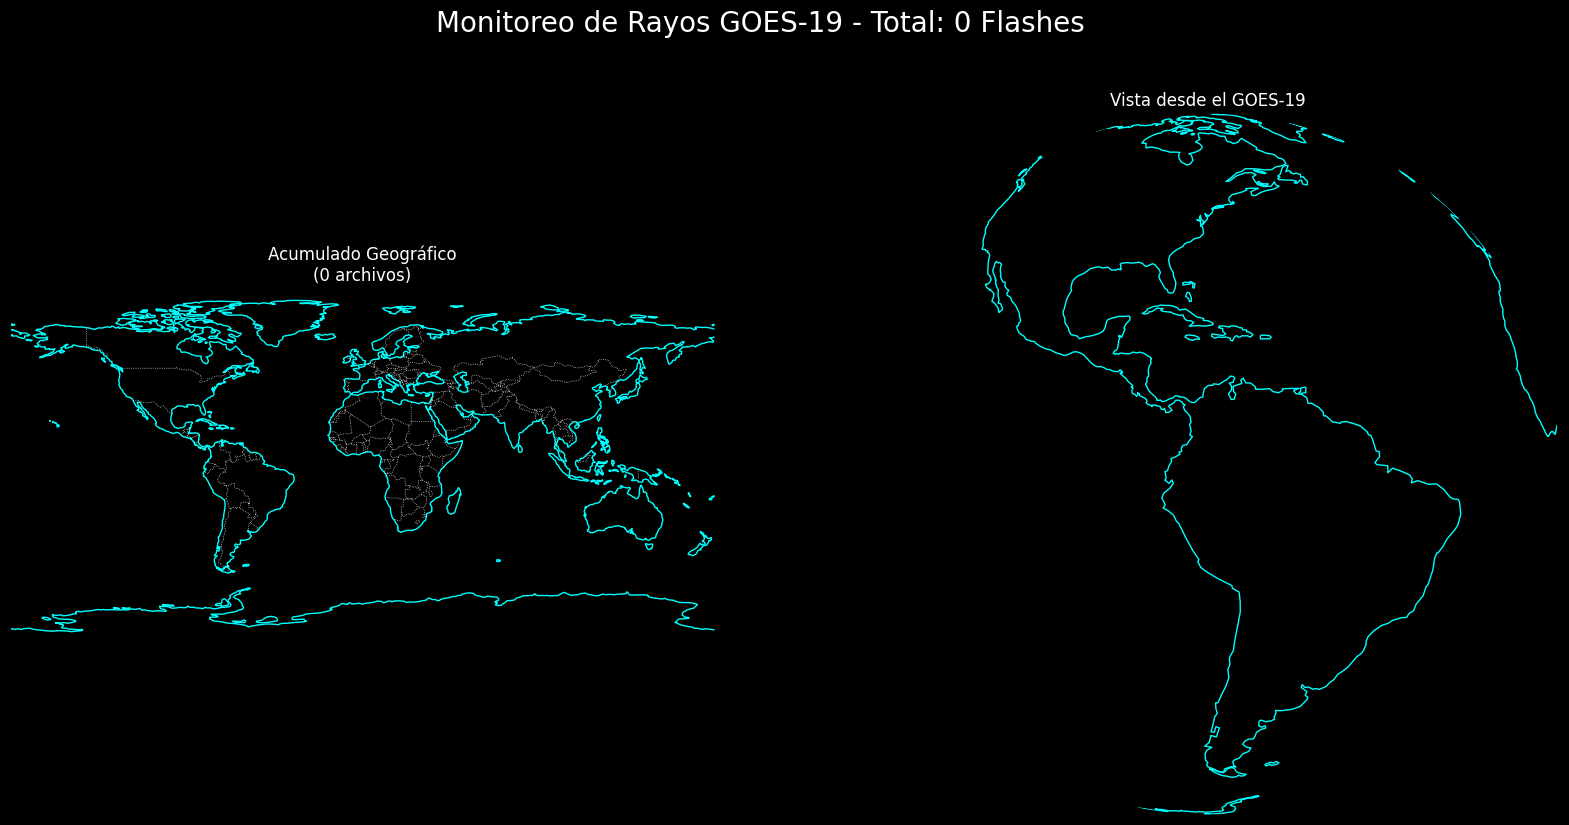

In [11]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os

# --- 1. CONFIGURACIÓN ---
path_to_files = '../../../data/raw/noaa-goes19/GLM-L2-LCFA' # Cambia esto a tu carpeta con los .nc
files = sorted(glob.glob(os.path.join(path_to_files, 'OR_GLM-L2-LCFA_G19_*.nc')))

all_lats = []
all_lons = []
all_energy = []

print(f"🔄 Procesando {len(files)} archivos...")

# --- 2. BUCLE DE LECTURA ---
for f in files:
    try:
        ds = nc.Dataset(f)
        all_lats.extend(ds.variables['flash_lat'][:])
        all_lons.extend(ds.variables['flash_lon'][:])
        all_energy.extend(ds.variables['flash_energy'][:])
        ds.close()
    except Exception as e:
        print(f"⚠️ Error en archivo {os.path.basename(f)}: {e}")

# Convertir a arrays de numpy
lats = np.array(all_lats)
lons = np.array(all_lons)
energy = np.array(all_energy)

print(f"✅ Total de rayos acumulados: {len(lats)}")

# --- 3. VISUALIZACIÓN DUAL (WGS84 y DISCO) ---
fig = plt.figure(figsize=(20, 10), facecolor='black')

# Definir proyecciones
proj_wgs84 = ccrs.PlateCarree()
proj_goes = ccrs.Geostationary(central_longitude=-75.0)

# A. SUBPLOT WGS84
ax1 = fig.add_subplot(1, 2, 1, projection=proj_wgs84)
ax1.set_facecolor('black')
ax1.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1)
ax1.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5, linestyle=':')

if len(lats) > 0:
    sc1 = ax1.scatter(lons, lats, c=energy, s=15, cmap='magma', 
                      transform=proj_wgs84, alpha=0.7)
    ax1.set_extent([lons.min()-2, lons.max()+2, lats.min()-2, lats.max()+2])

ax1.set_title(f"Acumulado Geográfico\n({len(files)} archivos)", color='white')

# B. SUBPLOT DISCO COMPLETO
ax2 = fig.add_subplot(1, 2, 2, projection=proj_goes)
ax2.set_facecolor('black')
ax2.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1)
ax2.set_global()

if len(lats) > 0:
    sc2 = ax2.scatter(lons, lats, c=energy, s=10, cmap='magma', 
                      transform=proj_wgs84, alpha=0.5)

ax2.set_title("Vista desde el GOES-19", color='white')

plt.suptitle(f"Monitoreo de Rayos GOES-19 - Total: {len(lats)} Flashes", 
             color='white', fontsize=20, y=0.95)

plt.show()

🔥 Generando mapa de calor de 4320 archivos...


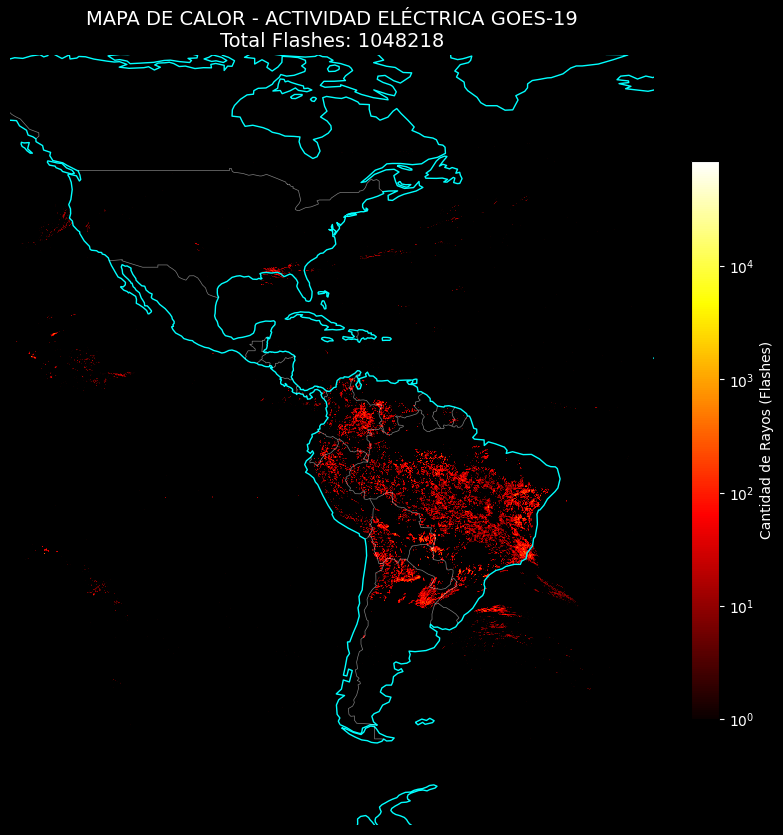

In [12]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm

# --- 1. ACUMULACIÓN DE DATOS ---
all_lats = []
all_lons = []

print(f"🔥 Generando mapa de calor de {len(archivos)} archivos...")

for f in archivos:
    try:
        ds = nc.Dataset(f)
        lats = ds.variables['flash_lat'][:]
        lons = ds.variables['flash_lon'][:]
        lons = np.where(lons > 180, lons - 360, lons)
        all_lats.extend(lats)
        all_lons.extend(lons)
        ds.close()
    except:
        continue

lons = np.array(all_lons)
lats = np.array(all_lats)

# --- 2. CREACIÓN DEL HISTOGRAMA 2D (EL "HEAT") ---
# Definimos la resolución del mapa de calor (ej. cada 0.1 grados)
res = 0.1 
lon_bins = np.arange(lons.min(), lons.max(), res)
lat_bins = np.arange(lats.min(), lats.max(), res)

# Calculamos la densidad
heatmap, xedges, yedges = np.histogram2d(lons, lats, bins=[lon_bins, lat_bins])

# --- 3. PLOTEO ---
fig = plt.figure(figsize=(12, 10), facecolor='black')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('black')

# Fondo y costas
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1, zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5, alpha=0.5, zorder=3)

# Dibujar el Heatmap
# Usamos LogNorm para que las zonas de pocos rayos también se vean
im = ax.pcolormesh(xedges, yedges, heatmap.T, 
                   cmap='hot', 
                   norm=LogNorm(vmin=1, vmax=heatmap.max()),
                   transform=ccrs.PlateCarree(),
                   zorder=2)

# Zoom a la zona de actividad
ax.set_extent([lons.min()-1, lons.max()+1, lats.min()-1, lats.max()+1])

# Barra de color profesional
cbar = plt.colorbar(im, fraction=0.03, pad=0.04)
cbar.set_label('Cantidad de Rayos (Flashes)', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.title(f"MAPA DE CALOR - ACTIVIDAD ELÉCTRICA GOES-19\nTotal Flashes: {len(lons)}", 
          color='white', fontsize=14)

plt.show()

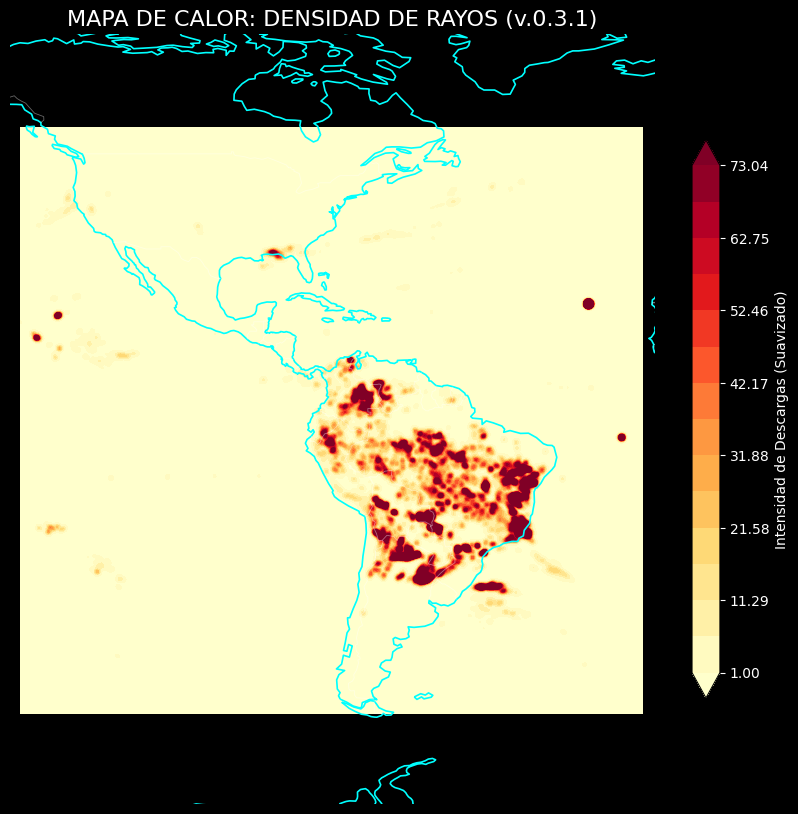

In [13]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter # Para suavizar las manchas

# --- 1. PROCESAMIENTO ---
# (Asumimos que lons y lats ya están cargados de tu bucle anterior)

# Crear el histograma con una resolución un poco más gruesa para agrupar mejor
res = 0.2 
lon_bins = np.arange(lons.min(), lons.max(), res)
lat_bins = np.arange(lats.min(), lats.max(), res)

heatmap, xedges, yedges = np.histogram2d(lons, lats, bins=[lon_bins, lat_bins])

# --- TRUCO DE TESIS: Suavizado Gaussiano ---
# Esto convierte los "cuadraditos" en manchas de calor suaves y naturales
heatmap_smoothed = gaussian_filter(heatmap.T, sigma=1.5)

# --- 2. PLOTEO ---
fig = plt.figure(figsize=(12, 10), facecolor='black')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('black')

ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1.2, zorder=5)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.6, alpha=0.4, zorder=5)

# Definimos niveles de color específicos para forzar el contraste
# Desde 1 rayo hasta el máximo, repartido en 15 niveles
levels = np.linspace(1, np.percentile(heatmap_smoothed, 99), 15)

# Dibujar el mapa de calor con contornos rellenos
im = ax.contourf(xedges[:-1], yedges[:-1], heatmap_smoothed, 
                 levels=levels,
                 cmap='YlOrRd', # De amarillo (poco) a rojo (mucho)
                 extend='both',
                 transform=ccrs.PlateCarree(),
                 zorder=2)

# Zoom dinámico
ax.set_extent([lons.min()-2, lons.max()+2, lats.min()-2, lats.max()+2])

# Barra de color
cbar = plt.colorbar(im, fraction=0.03, pad=0.04)
cbar.set_label('Intensidad de Descargas (Suavizado)', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.title("MAPA DE CALOR: DENSIDAD DE RAYOS (v.0.3.1)", color='white', size=16)
plt.show()

⌛ Procesando 4320 archivos para el Mapa de Calor...


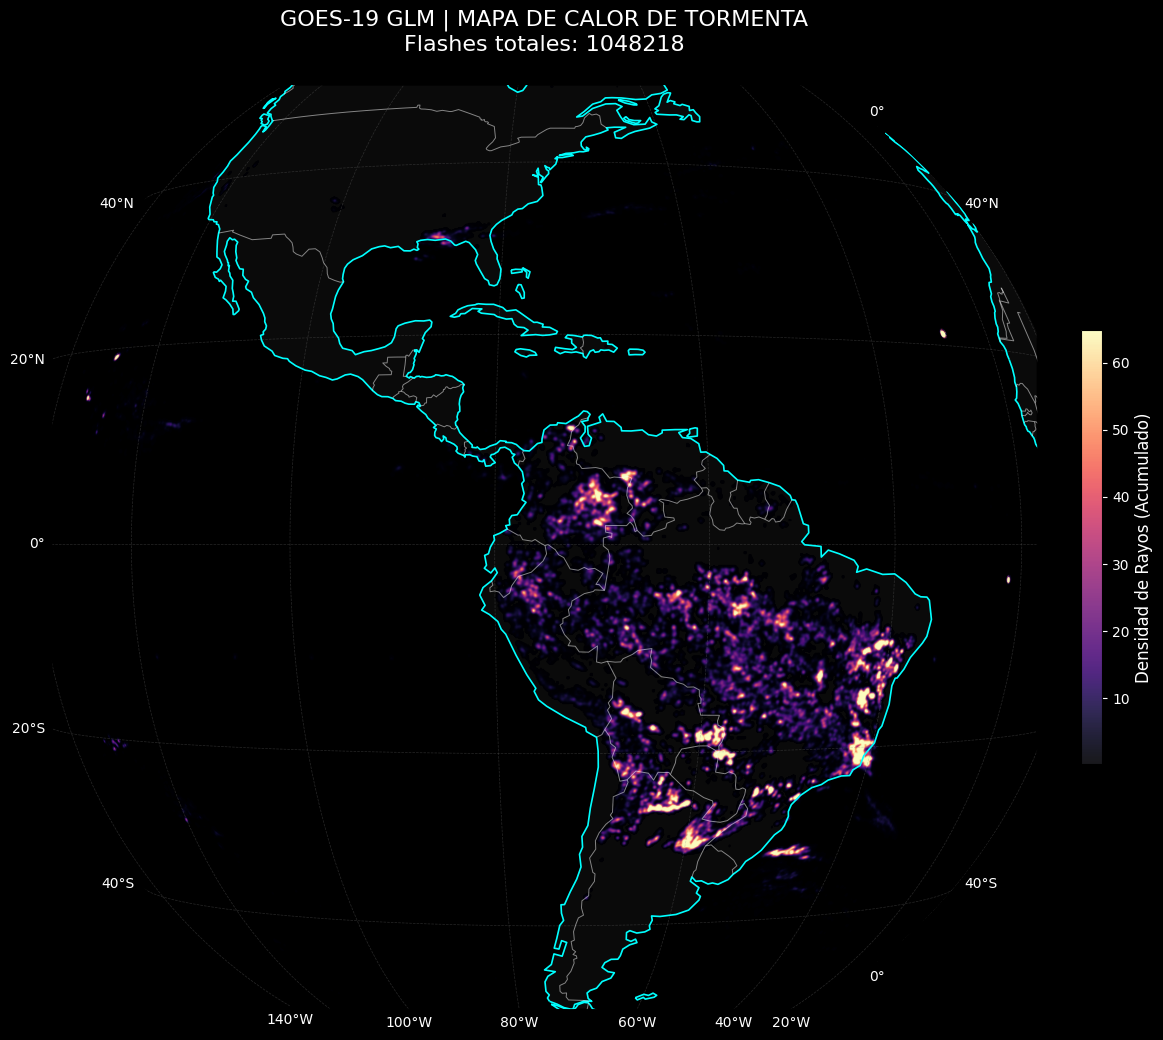

In [14]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter
import os

# --- 1. CARGA DE DATOS (Asegúrate de tener la lista 'archivos' definida) ---
lats_total = []
lons_total = []

print(f"⌛ Procesando {len(archivos)} archivos para el Mapa de Calor...")

for f in archivos:
    try:
        ds = nc.Dataset(f)
        la = ds.variables['flash_lat'][:]
        lo = ds.variables['flash_lon'][:]
        # Normalizar longitud a -180, 180
        lo = np.where(lo > 180, lo - 360, lo)
        lats_total.extend(la)
        lons_total.extend(lo)
        ds.close()
    except:
        continue

lons = np.array(lons_total)
lats = np.array(lats_total)

# --- 2. CREACIÓN DE LA GRILLA DE DENSIDAD ---
res = 0.1  # Resolución en grados
lon_bins = np.arange(lons.min() - 1, lons.max() + 1, res)
lat_bins = np.arange(lats.min() - 1, lats.max() + 1, res)

# Histogram2d devuelve los bordes (edges)
heatmap, xedges, yedges = np.histogram2d(lons, lats, bins=[lon_bins, lat_bins])

# Suavizado para estética "climática"
heatmap_smoothed = gaussian_filter(heatmap.T, sigma=1.2)

# Enmascarar para eliminar el "cuadrado" de fondo
heatmap_masked = np.where(heatmap_smoothed < 0.1, np.nan, heatmap_smoothed)

# CORRECCIÓN DE DIMENSIONES: Calcular los centros de los bins
# Esto hace que X e Y tengan la misma forma que la matriz heatmap_masked
lon_centers = (xedges[:-1] + xedges[1:]) / 2
lat_centers = (yedges[:-1] + yedges[1:]) / 2

# --- 3. CONFIGURACIÓN DEL MAPA ---
fig = plt.figure(figsize=(14, 12), facecolor='black')
# Proyección de disco para GOES-19
goes_crs = ccrs.Geostationary(central_longitude=-75.0)
ax = plt.axes(projection=goes_crs)
ax.set_facecolor('black')

# Capas geográficas
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1.2, zorder=4)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.7, alpha=0.5, zorder=4)
ax.add_feature(cfeature.LAND, facecolor='#0a0a0a', zorder=1)

# --- 4. DIBUJAR MAPA DE CALOR ---
vmax_val = np.nanpercentile(heatmap_masked, 98) # Contraste dinámico

im = ax.pcolormesh(lon_centers, lat_centers, heatmap_masked,
                   cmap='magma', 
                   shading='gouraud', 
                   transform=ccrs.PlateCarree(),
                   zorder=2,
                   alpha=0.9,
                   vmax=vmax_val)

# --- 5. DETALLES FINALES ---
# Zoom automático a la zona con datos
ax.set_extent([lons.min()-3, lons.max()+3, lats.min()-3, lats.max()+3], crs=ccrs.PlateCarree())

# Grilla de coordenadas
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'color': 'white'}
gl.ylabel_style = {'color': 'white'}

# Barra de color
cbar = plt.colorbar(im, fraction=0.02, pad=0.04)
cbar.set_label('Densidad de Rayos (Acumulado)', color='white', size=12)
cbar.ax.yaxis.set_tick_params(color='white', labelcolor='white')

plt.title(f"GOES-19 GLM | MAPA DE CALOR DE TORMENTA\nFlashes totales: {len(lons)}", 
          color='white', pad=25, fontsize=16)

plt.show()

In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import geometry, kd_tree
from scipy.ndimage import gaussian_filter
import os

# --- 1. CARGA Y LIMPIEZA DE DATOS ---
lats_total = []
lons_total = []

print(f"⌛ Procesando {len(archivos)} archivos...")

for f in archivos:
    try:
        ds = nc.Dataset(f)
        la = ds.variables['flash_lat'][:]
        lo = ds.variables['flash_lon'][:]
        lo = np.where(lo > 180, lo - 360, lo)
        lats_total.extend(la)
        lons_total.extend(lo)
        ds.close()
    except:
        continue

# --- CORRECCIÓN CRÍTICA PARA PYRESAMPLE ---
# Forzamos float64 y aplanamos las dimensiones para evitar el ValueError
lons_arr = np.asanyarray(lons_total, dtype=np.float64).ravel()
lats_arr = np.asanyarray(lats_total, dtype=np.float64).ravel()

print(f"✅ Datos listos: {len(lons_arr)} flashes cargados.")

# --- 2. DEFINICIÓN DEL ÁREA (ESTILO SATPY) ---
# Creamos una definición de área dinámica basada en los límites de tus rayos
area_id = 'goes_east_auto'
projection = {'proj': 'geos', 'h': '35786023', 'lon_0': '-75', 'sweep': 'x'}

# Definimos la resolución (ej. 800x800 píxeles)
shape = (800, 800)

# Calculamos el extent aproximado en grados y lo centramos
# (Esto es una simplificación, pyresample prefiere metros pero usaremos 
# PlateCarree para definir el área de forma más intuitiva para la tesis)
area_def = geometry.AreaDefinition.from_extent(
    area_id, 
    'EPSG:4326', # Coordenadas geográficas WGS84
    shape, 
    [lons_arr.min()-2, lats_arr.min()-2, lons_arr.max()+2, lats_arr.max()+2]
)

# --- 3. RASTERIZACIÓN ---
# Definimos la geometría de los puntos originales (Swath)
swath_def = geometry.SwathDefinition(lons=lons_arr, lats=lats_arr)

# Convertimos los puntos a una grilla (Raster)
# radius_of_influence: 20000 metros (20km) es ideal para rayos
heatmap_raw = kd_tree.resample_nearest(
    swath_def, 
    np.ones(len(lons_arr)), 
    area_def, 
    radius_of_influence=20000, 
    fill_value=0
)

# Suavizado Gaussiano para efecto de "Mapa de Calor"
heatmap_final = gaussian_filter(heatmap_raw.astype(float), sigma=1.5)
heatmap_final = np.where(heatmap_final < 0.01, np.nan, heatmap_final)

# --- 4. VISUALIZACIÓN CORREGIDA ---
fig = plt.figure(figsize=(12, 12), facecolor='black')

# Obtenemos el CRS de Cartopy desde el AreaDefinition
map_crs = area_def.to_cartopy_crs()
ax = plt.axes(projection=map_crs)
ax.set_facecolor('black')

# Capas geográficas
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1, zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5, alpha=0.5, zorder=3)

# CORRECCIÓN AQUÍ: 
# Si to_cartopy_extent() falla, usamos area_extent que es [x_min, y_min, x_max, y_max]
# Pero imshow espera [x_min, x_max, y_min, y_max]
e = area_def.area_extent
cartopy_extent = [e[0], e[2], e[1], e[3]]

im = ax.imshow(heatmap_final, 
               extent=cartopy_extent, 
               origin='upper', 
               cmap='magma', 
               vmax=np.nanpercentile(heatmap_final, 98),
               zorder=2)

# Detalles estéticos
plt.colorbar(im, label='Densidad de Flashes', fraction=0.03, pad=0.04, extend='max')
plt.title(f"ANÁLISIS GLM GOES-19\nFlashes: {len(lons_arr):,}", color='white', size=16, pad=20)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import geometry, kd_tree
from scipy.ndimage import gaussian_filter

# 1. PREPARACIÓN DE DATOS
lons_arr = np.asanyarray(lons_total, dtype=np.float64).ravel()
lats_arr = np.asanyarray(lats_total, dtype=np.float64).ravel()
swath_def = geometry.SwathDefinition(lons=lons_arr, lats=lats_arr)

# 2. DEFINICIÓN DEL DISCO COMPLETO (FULL DISK)
# El disco completo del GOES en metros proyectados va aprox. de -5.4M a 5.4M
proj_goes = {'proj': 'geos', 'h': '35786023', 'lon_0': '-75', 'sweep': 'x'}
full_disk_extent = [-5434894.8, -5434894.8, 5434894.8, 5434894.8]
shape = (1000, 1000) # Resolución del renderizado

area_full_disk = geometry.AreaDefinition.from_extent(
    'goes_full_disk', 
    proj_goes, 
    shape, 
    full_disk_extent
)

# 3. RASTERIZACIÓN
# Para el disco completo, necesitamos un radio de influencia mayor para que los puntos se vean
heatmap = kd_tree.resample_nearest(
    swath_def, 
    np.ones(len(lons_arr)), 
    area_full_disk, 
    radius_of_influence=50000, # 50km para que sea visible en escala global
    fill_value=0
)

# Suavizado y limpieza
heatmap = gaussian_filter(heatmap.astype(float), sigma=1.2)
heatmap = np.where(heatmap < 0.01, np.nan, heatmap)

# 4. PLOTEO DEL DISCO COMPLETO
fig = plt.figure(figsize=(12, 12), facecolor='black')
ax = plt.axes(projection=area_full_disk.to_cartopy_crs())
ax.set_facecolor('black')

# Añadir capas geográficas
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=0.8, zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.4, alpha=0.5, zorder=3)

# Dibujar el "limbo" de la Tierra (el círculo del planeta)
ax.set_global() # Esto asegura que se vea todo el espacio del satélite

# Mostrar los datos
e = area_full_disk.area_extent
im = ax.imshow(
    heatmap, 
    extent=[e[0], e[2], e[1], e[3]], 
    origin='upper', 
    cmap='magma', 
    vmax=np.nanpercentile(heatmap, 99),
    zorder=2
)

plt.title(f"GOES-19 GLM | FULL DISK VIEW\n{len(lons_arr):,} Flashes", 
          color='white', size=16, pad=20)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import geometry, kd_tree
from scipy.ndimage import gaussian_filter

# --- 1. DATOS ---
lons_arr = np.asanyarray(lons_total, dtype=np.float64).ravel()
lats_arr = np.asanyarray(lats_total, dtype=np.float64).ravel()
swath_def = geometry.SwathDefinition(lons=lons_arr, lats=lats_arr)

# --- 2. ÁREA WGS84 COMPLETA (3600x1800) ---
area_id = 'wgs84_hi_res'
proj_wgs84 = {'proj': 'longlat', 'datum': 'WGS84'}

# Definimos el tamaño exacto que pediste
shape = (1800, 3600) 

# Extensión global para que la relación 3600x1800 sea perfecta:
# [-180, -90, 180, 90]
extent = [-180, -90, 180, 90] 

area_wgs84 = geometry.AreaDefinition.from_extent(
    area_id, proj_wgs84, shape, extent
)

# --- 3. RASTERIZACIÓN ---
# Aumentamos ligeramente el radio de influencia porque el mapa es mucho más grande
heatmap = kd_tree.resample_nearest(
    swath_def, 
    np.ones(len(lons_arr)), 
    area_wgs84, 
    radius_of_influence=40000, 
    fill_value=0
)

# Suavizado para evitar pixelado en alta resolución
heatmap = gaussian_filter(heatmap.astype(float), sigma=2.0)
heatmap = np.where(heatmap < 0.01, np.nan, heatmap)

# --- 4. VISUALIZACIÓN ---
# Configuramos el tamaño de la figura en pulgadas para que al guardar 
# con 100 DPI dé exactamente 3600x1800 píxeles
fig = plt.figure(figsize=(36, 18), facecolor='black')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('black')

# Capas geográficas detalladas
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=1.5, zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.8, alpha=0.6, zorder=3)
ax.add_feature(cfeature.LAND, facecolor='#050505', zorder=1)

# Dibujar Heatmap
e = area_wgs84.area_extent
im = ax.imshow(
    heatmap, 
    extent=[e[0], e[2], e[1], e[3]], 
    origin='upper', 
    cmap='magma', 
    vmax=np.nanpercentile(heatmap, 99.5), # Subimos el percentil para resaltar núcleos
    zorder=2
)

# Estética de Tesis
plt.title(f"GOES-19 GLM | MAPA GLOBAL DE DENSIDAD (WGS84)\nFlashes: {len(lons_arr):,}", 
          color='white', size=30, pad=40)

# Guardar la imagen en alta resolución
# plt.savefig('mapa_rayos_3600x1800.png', facecolor='black', bbox_inches='tight', dpi=100)

plt.show()

In [ ]:
import numpy as np
import xarray as xr
from satpy import Scene
from pyresample import geometry, kd_tree
from scipy.ndimage import gaussian_filter
from datetime import datetime
import matplotlib.pyplot as plt

# --- 1. PROCESAMIENTO ---
lons_arr = np.asanyarray(lons_total, dtype=np.float64).ravel()
lats_arr = np.asanyarray(lats_total, dtype=np.float64).ravel()
swath_def = geometry.SwathDefinition(lons=lons_arr, lats=lats_arr)

proj_goes = {'proj': 'geos', 'h': '35786023', 'lon_0': '-75', 'sweep': 'x'}
full_disk_extent = [-5434894.8, -5434894.8, 5434894.8, 5434894.8]
area_def = geometry.AreaDefinition.from_extent('goes_fd', proj_goes, (1800, 1800), full_disk_extent)

heatmap_raw = kd_tree.resample_nearest(swath_def, np.ones(len(lons_arr)), area_def, 
                                      radius_of_influence=50000, fill_value=0)
heatmap_smoothed = gaussian_filter(heatmap_raw.astype(float), sigma=1.5)

# --- 2. INYECCIÓN EN ESCENA (SATPY) ---
data_array = xr.DataArray(
    heatmap_smoothed,
    dims=('y', 'x'),
    attrs={'area': area_def, 'start_time': datetime(2026, 2, 9), 'name': 'lightning_heatmap'}
)

scn = Scene()
scn['lightning_heatmap'] = data_array

# --- 3. VISUALIZACIÓN ROBUSTA (MATPLOTLIB + SATPY METADATA) ---
# Usamos el objeto Scene para mantener la coherencia, pero ploteamos con el control de Matplotlib
fig = plt.figure(figsize=(12, 12), facecolor='black')
ax = plt.axes(projection=scn['lightning_heatmap'].attrs['area'].to_cartopy_crs())
ax.set_facecolor('black')

# Capas geográficas
ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=0.8, zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.4, alpha=0.5, zorder=3)

# Normalización de color (evita que un solo rayo sature todo)
vmax_val = np.nanpercentile(scn['lightning_heatmap'].values, 99)

# Ploteo usando los datos del DataArray inyectado
im = ax.imshow(scn['lightning_heatmap'].values, 
               extent=scn['lightning_heatmap'].attrs['area'].area_extent_ll, # Límites en Lat/Lon si es necesario
               transform=ccrs.PlateCarree(), # Si el extent está en grados
               origin='upper', 
               cmap='magma', 
               vmax=vmax_val,
               zorder=2)

# Si prefieres usar la extensión proyectada (más exacto para Full Disk):
e = scn['lightning_heatmap'].attrs['area'].area_extent
im = ax.imshow(scn['lightning_heatmap'].values, 
               extent=[e[0], e[2], e[1], e[3]], 
               origin='upper', 
               cmap='magma', 
               vmax=vmax_val,
               zorder=2)

plt.title(f"GOES-19 GLM | SATPY INJECTED SCENE\nFlashes: {len(lons_arr):,}", color='white', pad=20)
plt.show()

In [ ]:
import glob
import os

ruta_base = "../../data/raw"

# El **/ indica búsqueda recursiva en todas las subcarpetas
patron = os.path.join(ruta_base, "**/OR_GLM-L2-LCFA_G19_*.nc")

# recursive=True es OBLIGATORIO para que el ** funcione
archivos = sorted(glob.glob(patron, recursive=True))

print(f"✅ Total de archivos LCFA (G19) encontrados: {len(archivos)}")

In [ ]:
import sys
import os
from pathlib import Path
from satpy import  Scene 
import matplotlib.pyplot as plt
from satpy.enhancements.enhancer import get_enhanced_image
# Retrocedemos un nivel desde 'notebooks' para llegar a la raíz del proyecto
root_path = Path(os.getcwd()).parent
sys.path.append(str(root_path / "src"))

# Ahora puedes importar tu config normalmente
from goes_processor import my_config_satpy

In [ ]:
from satpy import Scene
from satpy.enhancements.enhancer import get_enhanced_image

# 1. Cargar archivos (ABI + GLM)
# Satpy asociará automáticamente cada archivo con su reader correspondiente
scn = Scene(filenames=archivos, reader=['abi_l2_nc', 'glm_l2'])

# 2. Cargar productos
# Nota: 'lightning_heatmap' usará tu LightningHeatmapCompositor
scn.load(['my_fdc_fn03', 'lightning_heatmap'])

# 3. UNIFICACIÓN GEOMÉTRICA (Paso Crítico)
# Resampleamos a la resolución del FDC (o a un área definida) 
# para que los rayos y los incendios coincidan píxel a píxel.
scn_res = scn.resample(scn.min_area()) 

# 4. GENERAR IMÁGENES REALZADAS
# Aquí Satpy busca en tus YAML el stretch y el colormap 'magma'
img_lightning = get_enhanced_image(scn_res['lightning_heatmap'])
img_fdc = get_enhanced_image(scn_res['my_fdc_fn03'])

# 5. VISUALIZACIÓN
# Esto aplicará el 'magma' que definimos y el stretch para resaltar los rayos
img_lightning.show()

# EXTRA: Si quieres ver los rayos SOBRE los incendios en una sola imagen:
img_combined = img_fdc.mix(img_lightning)
img_combined.show()

In [ ]:
# Celda 1: Importaciones
from satpy import Scene
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

In [ ]:
# Celda 2: Ruta al archivo (ajusta si está en otra carpeta)
file_path = Path("OR_GLM-L2-LCFA_G18_s20240030000000_e20240030000200_c20240030000220.nc")

if not file_path.exists():
    print("Archivo no encontrado. Verifica la ruta.")
else:
    print(f"Archivo encontrado: {file_path}")

In [ ]:
# Celda 3: Cargar con SatPy (reader específico para GLM L2)
scn = Scene(filenames=[str(file_path)])
print("Escena GLM cargada correctamente con SatPy.")

In [ ]:
from satpy import Scene
import glob

# 1. Definimos los archivos
files = glob.glob('OR_GLM-L2-LCFA_*.nc')

# 2. El TRUCO: Forzamos la asignación de archivos al lector 
# aunque Satpy crea que no son compatibles
reader_kwargs = {'decode_times': True}
scn = Scene(filenames={'glm_l2': files}) # Pasamos un diccionario: {lector: lista_de_archivos}

try:
    # 3. Cargamos el dataset
    scn.load(['flash_extent_density'])
    
    # 4. Resample y Plot
    resampled = scn.resample(resampler='native')
    resampled.show('flash_extent_density')
    print("✅ ¡Forzado exitoso! Imagen generada.")
except Exception as e:
    print(f"❌ Error al cargar: {e}")

In [ ]:
from satpy import Scene
import glob

# 1. Definimos los archivos
files = glob.glob('OR_GLM-L2-LCFA_*.nc')
files

In [ ]:
from satpy import Scene
import glob

# 1. Definimos los archivos
files = glob.glob('OR_GLM-L2-LCFA_*.nc')

# 2. El TRUCO: Forzamos la asignación de archivos al lector 
# aunque Satpy crea que no son compatibles
reader_kwargs = {'decode_times': True}
scn = Scene(filenames={'glm_l2': files}) # Pasamos un diccionario: {lector: lista_de_archivos}

try:
    # 3. Cargamos el dataset
    scn.load(['flash_extent_density'])
    
    # 4. Resample y Plot
    resampled = scn.resample(resampler='native')
    resampled.show('flash_extent_density')
    print("✅ ¡Forzado exitoso! Imagen generada.")
except Exception as e:
    print(f"❌ Error al cargar: {e}")

In [ ]:
import netCDF4 as nc
import matplotlib.pyplot as plt

file_name = "OR_GLM-L2-LCFA_G18_s20240030000000_e20240030000200_c20240030000220.nc"

try:
    # Abrir el archivo directamente
    ds = nc.Dataset(file_name)
    
    # Extraer las coordenadas de los flashes (rayos)
    lats = ds.variables['flash_lat'][:]
    lons = ds.variables['flash_lon'][:]
    energy = ds.variables['flash_energy'][:]
    
    print(f"✅ Archivo leído correctamente: {file_name}")
    print(f"⚡ Rayos detectados: {len(lats)}")
    
    # Graficar puntos crudos
    plt.figure(figsize=(12, 6))
    plt.style.use('dark_background')
    
    # Scatter plot de los rayos
    sc = plt.scatter(lons, lats, c=energy, s=15, cmap='autumn', alpha=0.7)
    
    plt.colorbar(sc, label='Energía [J]')
    plt.title(f"Datos Crudos GLM - {file_name}")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(alpha=0.2)
    
    plt.show()
    ds.close()

except Exception as e:
    print(f"❌ Error al abrir el NetCDF: {e}")

In [ ]:
import requests
import netCDF4 as nc
import os

# URL oficial de la NOAA (AWS S3 Público)
url = "https://noaa-goes18.s3.amazonaws.com/GLM-L2-LCFA/2024/003/00/OR_GLM-L2-LCFA_G18_s20240030000000_e20240030000200_c20240030000220.nc"
file_name = "TEST_GLM_G18.nc"

print(f"📥 Descargando archivo desde AWS...")
r = requests.get(url, stream=True)

if r.status_code == 200:
    with open(file_name, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"✅ Descarga finalizada: {os.path.getsize(file_name)/1024:.2f} KB")
    
    # PROBAR SI ESTE SI ABRE
    try:
        with nc.Dataset(file_name, 'r') as ds:
            n = len(ds.dimensions['number_of_events'])
            print(f"🔥 ¡POR FIN! Archivo abierto. Eventos: {n}")
    except Exception as e:
        print(f"❌ Sigue fallando: {e}")
else:
    print(f"❌ No se pudo acceder a la URL. Status: {r.status_code}")

In [ ]:
# Instala esto primero en tu terminal: pip install h5netcdf
import xarray as xr

try:
    # Intentamos abrir usando el motor alternativo h5netcdf
    ds = xr.open_dataset('TEST_GLM_G18.nc', engine='h5netcdf')
    print("🔥 ¡FUNCIONÓ con h5netcdf!")
    print(ds)
except Exception as e:
    print(f"❌ Ni h5netcdf pudo: {e}")

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

file = 'OR_GLM-L2-LCFA_G18_s20240030000000_e20240030000200_c20240030000220.nc'

# 1. Cargamos con xarray (que ya vimos que funciona)
ds = xr.open_dataset(file, engine='netcdf4')

# 2. Extraemos las coordenadas de los eventos (son más numerosos que los flashes)
lons = ds.event_lon.values
lats = ds.event_lat.values
energy = ds.event_energy.values

# 3. Graficamos
plt.figure(figsize=(12, 8), facecolor='black')
ax = plt.axes()
ax.set_facecolor('black')

# Si hay datos, graficamos. Si no, avisamos.
if len(lons) > 0:
    # Usamos un tamaño s=20 y un alpha alto para que se vean
    # El color 'cyan' o 'yellow' destaca mucho sobre negro
    scatter = ax.scatter(lons, lats, c=energy, s=25, 
                        cmap='Wistia', alpha=1, edgecolors='white', linewidth=0.2)
    
    plt.colorbar(scatter, label='Energía del Evento')
    
    # Ajustamos el zoom a donde están los rayos
    ax.set_xlim(lons.min() - 0.5, lons.max() + 0.5)
    ax.set_ylim(lats.min() - 0.5, lats.max() + 0.5)
    print(f"✅ Se encontraron {len(lons)} eventos. Graficando...")
else:
    print("⚠️ El archivo no contiene eventos de rayos en estos 20 segundos.")

plt.title(f"Detección de Rayos GLM - Vista de Eventos\n{file}", color='white')
plt.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(colors='white')

plt.show()

In [ ]:
import glob
from lightning_utils import load_glm_as_scene

# Buscamos todos los archivos en tu carpeta de datos
files = glob.glob("../../data/raw/noaa-goes18/GLM-L2-LCFA/**/*.nc", recursive=True)

for f in files:
    try:
        # Cargamos la escena usando tu utilidad
        scn = load_glm_as_scene(f)
        
        # Ejemplo: Remuestrear a un área fija (puedes definir tu zona de estudio)
        # resampled_scn = scn.resample("mi_area_tesis")
        
        # Guardar resultado
        # resampled_scn.save_dataset('lightning_energy', filename=f"{f}.png")
        
        print(f"✅ Procesado: {f}")
        
    except Exception as e:
        print(f"❌ Error en {f}: {e}")

In [1]:
import glob
from lightning_utils import load_glm_as_scene
from pyresample import AreaDefinition

# 1. Definimos el área de tu tesis (Ejemplo: Una zona sobre Sudamérica/Pacífico)
# Puedes ajustar estos números: (proyección, nombre, id, proj_id, ancho, alto, extensión)
area_id = 'mi_zona_tesis'
description = 'Area enfocada en eventos detectados'
proj_id = 'laea' # Lambert Azimuthal Equal Area (buena para rayos)
projection = {'proj': 'laea', 'lat_0': -30, 'lon_0': -60, 'units': 'm'}
width = 500  # píxeles
height = 500 # píxeles
area_extent = (-2000000, -2000000, 2000000, 2000000) # Metros desde el centro

mi_area = AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent)

# 2. Bucle de procesamiento
archivos = glob.glob("../../data/raw/noaa-goes18/GLM-L2-LCFA/**/*.nc", recursive=True)

for f in archivos:
    try:
        scn = load_glm_as_scene(f)
        
        if scn is not None:
            # Forzamos el remuestreo a nuestra área definida
            # Usamos 'nearest' porque son puntos (rayos)
            resampled = scn.resample(mi_area, resampler='nearest')
            
            # Guardamos la imagen
            output_name = f.replace('.nc', '.png')
            resampled.save_dataset('lightning_energy', filename=output_name)
            
            print(f"✅ Procesado con éxito: {output_name}")
            
    except Exception as e:
        print(f"❌ Falló {f}: {e}")

INFO:satpy.scene:Not reducing data before resampling.
/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1573: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
INFO:satpy.scene:Not reducing data before resampling.


✅ Procesado con éxito: ../../data/raw/noaa-goes18/GLM-L2-LCFA/2024/003/00/OR_GLM-L2-LCFA_G18_s20240030000200_e20240030000400_c20240030000420.png


/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1573: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
INFO:satpy.scene:Not reducing data before resampling.
/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1573: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


✅ Procesado con éxito: ../../data/raw/noaa-goes18/GLM-L2-LCFA/2024/003/00/OR_GLM-L2-LCFA_G18_s20240030000400_e20240030001000_c20240030001016.png
✅ Procesado con éxito: ../../data/raw/noaa-goes18/GLM-L2-LCFA/2024/003/00/OR_GLM-L2-LCFA_G18_s20240030000000_e20240030000200_c20240030000220.png
